In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Add, Conv2DTranspose, LeakyReLU, add, ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, ELU
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as k
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.activations import elu, relu
from tensorflow.keras.applications import DenseNet121

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#tf.compat.v1.disable_eager_execution()

In [3]:
# download the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 13s 0us/step


In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

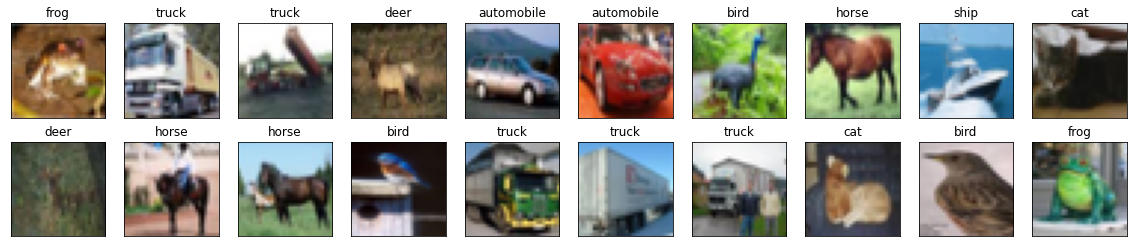

In [5]:
# show some sample images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = plt.subplot(2, 10, idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(x_train[idx])
  plt.title(class_names[int(y_train[idx])])

In [6]:
# change data type as float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [7]:
# normalize image data 
x_train = x_train / 255.
x_test = x_test / 255.

In [8]:
# one hot encoding
# Now we one hot encode outputs
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
# shape o images
print('Shape of taining images: ', x_train.shape)
print('Shape of taining labels: ', y_train.shape)
print()
print('Shape of testing images: ', x_test.shape)
print('Shape of testing labels: ', y_test.shape)

Shape of taining images:  (50000, 32, 32, 3)
Shape of taining labels:  (50000, 10)

Shape of testing images:  (10000, 32, 32, 3)
Shape of testing labels:  (10000, 10)


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
model = load_model('./drive/My Drive/PhD_Thesis/target_models/Dnet.h5')

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']       

In [14]:
predictions = model.predict(x_test[:1000])
#np.argmax(predictions[0])

In [15]:
x_test, y_test = x_test[:1000], y_test[:1000]

In [16]:
orig_loss, orig_accuracy = model.evaluate(x_test, y_test)
print()
print('Test Accuracy: ', round(orig_accuracy, 4))
print('Test Los: ', round(orig_loss, 4))

32/32 [==============================] - 2s 19ms/step - loss: 0.5453 - accuracy: 0.8240

Test Accuracy:  0.824
Test Los:  0.5453


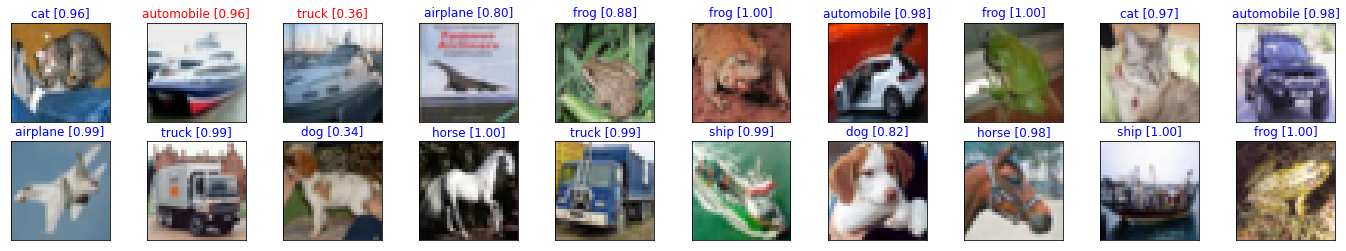

In [17]:
#show some test images
fig = plt.figure(figsize=(24, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(x_test[idx])
  
  if class_names[int(np.argmax(predictions[idx]))] == class_names[np.argmax(y_test[idx])]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color = color)

## 1. Fast Gradient Sign Attack and Reconstruction of Adversarial Example

In [20]:
l = [] 
for i in np.arange(len(y_test)):
  y = np.argmax(y_test[i])
  l.append(y)

y_test = np.asarray(l)
y_test.shape

(1000,)

In [19]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
images = tf.cast(x_test, dtype = tf.float32)
labels = tf.cast(y_test, dtype = tf.int32)

#images = ep.astensor(images)
#labels = ep.astensor(labels)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

eps = [0.3]

# create attack
attack = foolbox.attacks.FGSM()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c, epsilons = 0.005)

# adversarial purtubation
perturb = adv_img - x_test

In [ ]:
predictions = model.predict(adv_img.numpy())

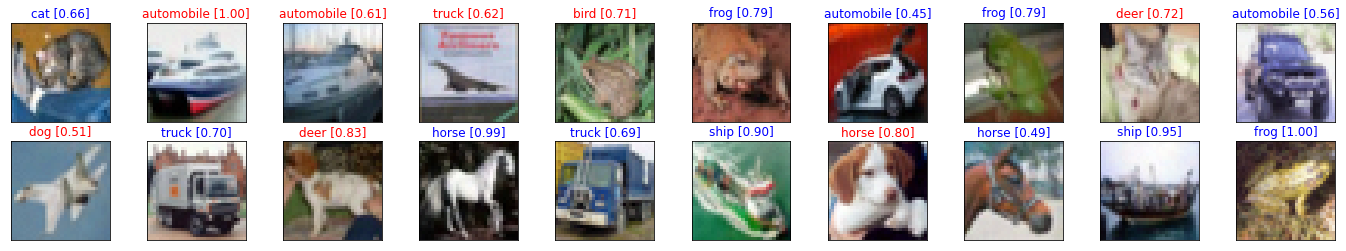

In [ ]:
#show some test images

fig = plt.figure(figsize=(24, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(np.clip(adv_img[idx].numpy(), 0, 1))
  
  if class_names[np.argmax(predictions[idx])] == class_names[y_test[idx]]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color = color)

In [ ]:
print("Average L1 Norm: ", round(tf.norm(perturb, ord = 1).numpy() / len(x_test), 4))
print("Average L2 Norm: ", round(tf.norm(perturb, ord = 2).numpy()/ len(x_test), 4))
print("Average L_inf Norm: ", round(tf.norm(perturb - x_test, ord = np.inf).numpy()/ len(x_test), 4))

Average L1 Norm:  15.3387
Average L2 Norm:  0.0088
Average L_inf Norm:  0.001


In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), tf.keras.utils.to_categorical(y_test, 10))
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 1s 35ms/step - loss: 2.0480 - accuracy: 0.4570

Model Accuracy on test images:  0.457
Model Loss on test images:  2.048


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove FGSM putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/cifar10/cifar10_fgsm.h5')

In [ ]:
# Restore adversarial images created due to FGSM attack 
denise_images =d_model.predict(adv_img.numpy())

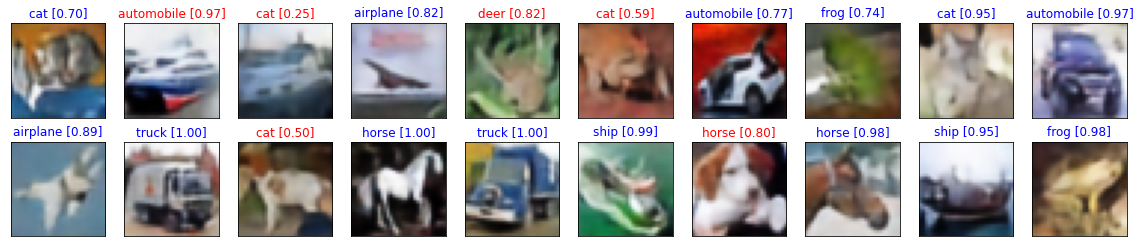

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  
  if class_names[y_test[idx]] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx])
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)  

In [ ]:
ssim = tf.image.ssim(x_test,denise_images , max_val = 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
ssim = ssim.numpy()
print("Average Structure Similarity Index between original and restored Examples:", round(ssim.mean(), 4))
print()

psnr = tf.image.psnr(x_test, denise_images, max_val = 255)
psnr = psnr.numpy()
print("Average Peak Signal-to-Noise Ratio between original and restored Examples:", psnr.mean())

Average Structure Similarity Index between original and restored Examples: 0.9045

Average Peak Signal-to-Noise Ratio between original and restored Examples: 76.21884


In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, tf.keras.utils.to_categorical(y_test, 10))
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 1s 35ms/step - loss: 1.0360 - accuracy: 0.6980

Model Accuracy on restored images:  0.698
Model Loss on test images:  1.036


In [ ]:
print('Sucess rate of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess rate of Defence Model:  0.8471


# 2. Basic Iterative Method (Attack) and Reconstruction of Adversarial Examples 

In [ ]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
images = tf.cast(x_test, dtype = tf.float32)
labels = tf.cast(y_test, dtype = tf.int32)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

eps = [0.3]

# create attack
attack = foolbox.attacks.L2BasicIterativeAttack()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c, epsilons = 0.25)

# adversarial purtubation
perturb = adv_img - x_test

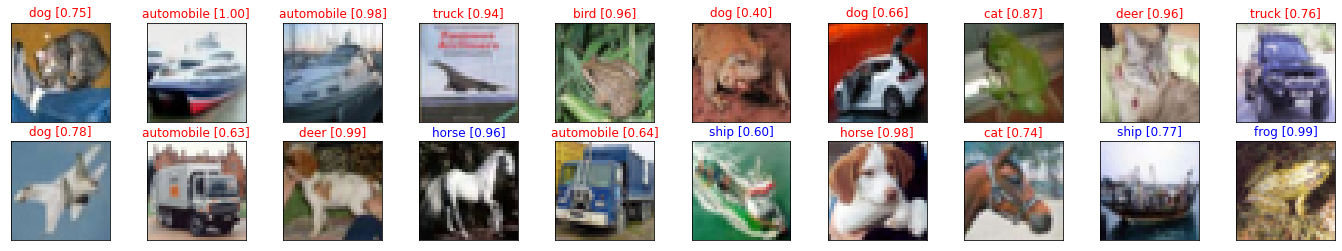

In [ ]:
adv_pred = model.predict(adv_img.numpy())

fig = plt.figure(figsize = (24, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_img[idx], 0, 1))
  
  if class_names[np.argmax(adv_pred[idx])] == class_names[y_test[idx]]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s [%.2f]' %(class_names[np.argmax(adv_pred[idx])], adv_pred[idx].max()), color = color)

In [ ]:
print("Average L1 Norm: ", round(tf.norm(perturb, ord = 1).numpy() / len(x_test), 4))
print("Average L2 Norm: ", round(tf.norm(perturb, ord = 2).numpy()/ len(x_test), 4))
print("Average L_inf Norm: ", round(tf.norm(perturb - x_test, ord = np.inf).numpy()/ len(x_test), 4))

Average L1 Norm:  9.6816
Average L2 Norm:  0.0079
Average L_inf Norm:  0.001


In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 1s 35ms/step - loss: 3.6416 - accuracy: 0.2570

Model Accuracy on test images:  0.257
Model Loss on test images:  3.6416


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove BIM putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/cifar10/cifar10_fgsm.h5')

In [ ]:
# Restore adversarial images created due to FGSM attack 
denise_images =d_model.predict(adv_img.numpy())

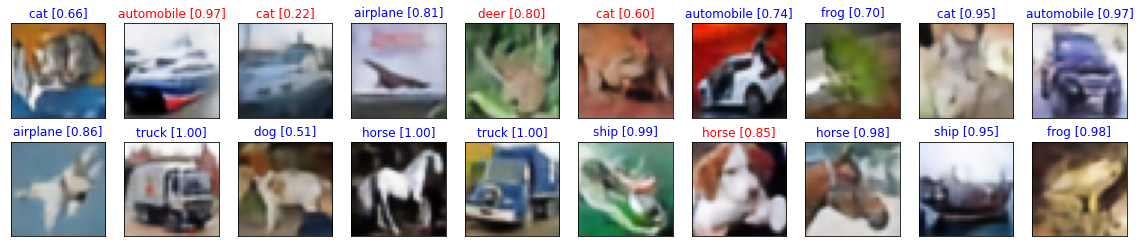

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  
  if class_names[y_test[idx]] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx])
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)
  

In [ ]:
ssim = tf.image.ssim(x_test,denise_images , max_val = 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
ssim = ssim.numpy()
print("Average Structure Similarity Index between original and restored Examples:", round(ssim.mean(), 4))
print()

psnr = tf.image.psnr(x_test, denise_images, max_val = 255)
psnr = psnr.numpy()
print("Average Peak Signal-to-Noise Ratio between original and restored Examples:", psnr.mean())

Average Structure Similarity Index between original and restored Examples: 0.9045

Average Peak Signal-to-Noise Ratio between original and restored Examples: 76.21855


In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 1s 39ms/step - loss: 1.0666 - accuracy: 0.6900

Model Accuracy on restored images:  0.69
Model Loss on test images:  1.0666


In [ ]:
print('Sucess rate of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess rate of Defence Model:  0.8374


#3. Projected Gradient Descent Attack and Reconstruction of Adverasarial Examples

In [ ]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
images = tf.cast(x_test, dtype = tf.float32)
labels = tf.cast(y_test, dtype = tf.int32)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

eps = [0.3]

# create attack
attack = foolbox.attacks.PGD()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c, epsilons = 0.01)

# adversarial purtubation
perturb = adv_img - x_test

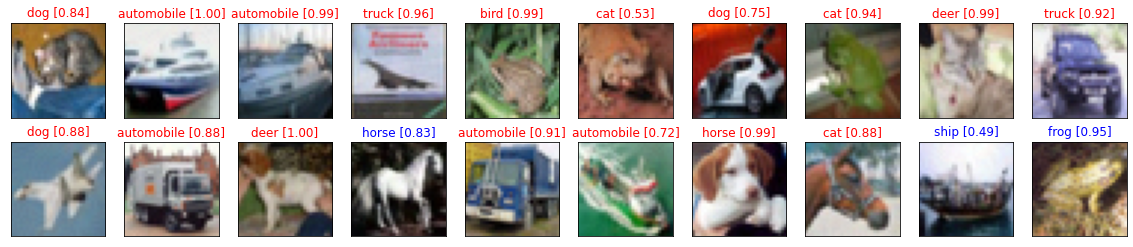

In [ ]:
adv_pred = model.predict(adv_img.numpy())
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_img[idx], 0, 1))
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[y_test[idx]]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s [%.2f]' %(class_names[np.argmax(adv_pred[idx])], adv_pred[idx].max()), color = color)

In [ ]:
print("Average L1 Norm: ", round(tf.norm(perturb, ord = 1).numpy() / len(x_test), 4))
print("Average L2 Norm: ", round(tf.norm(perturb, ord = 2).numpy() / len(x_test), 4))
print("Average L_inf Norm: ", round(tf.norm(perturb - x_test, ord = np.inf).numpy() / len(x_test), 4))

Average L1 Norm:  22.7
Average L2 Norm:  0.0141
Average L_inf Norm:  0.001


In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 3s 108ms/step - loss: 4.6836 - accuracy: 0.1590

Model Accuracy on test images:  0.159
Model Loss on test images:  4.6836


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove PGD putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/cifar10/cifar10_fgsm.h5')

In [ ]:
# Restore adversarial images created due to PGD attack 
denise_images =d_model.predict(adv_img.numpy())

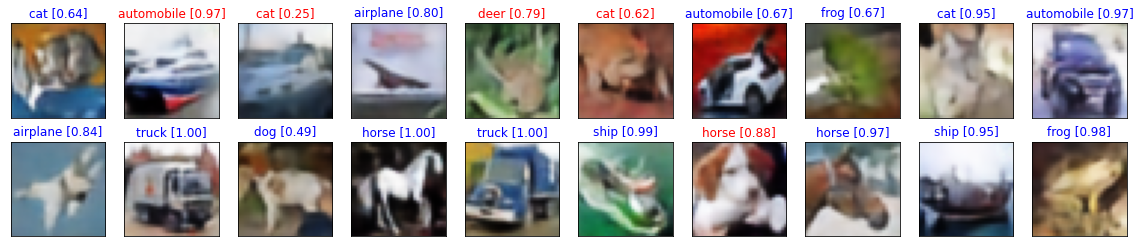

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  
  if class_names[y_test[idx]] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx])
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)

In [ ]:
ssim = tf.image.ssim(x_test, denise_images , max_val = 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
ssim = ssim.numpy()
print("Average Structure Similarity Index between original and restored Examples:", round(ssim.mean(), 4))
print()

psnr = tf.image.psnr(x_test, denise_images, max_val = 255)
psnr = psnr.numpy()
print("Average Peak Signal-to-Noise Ratio between original and restored Examples:", psnr.mean())

Average Structure Similarity Index between original and restored Examples: 0.9043

Average Peak Signal-to-Noise Ratio between original and restored Examples: 76.20714


In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 3s 106ms/step - loss: 1.1032 - accuracy: 0.6820

Model Accuracy on restored images:  0.682
Model Loss on test images:  1.1032


In [ ]:
print('Sucess rate of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess rate of Defence Model:  0.8277


#4. Deep Fool Attack

In [ ]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
images = tf.cast(x_test, dtype = tf.float32)
labels = tf.cast(y_test, dtype = tf.int32)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

eps = [0.3]

# create attack
attack = foolbox.attacks.L2DeepFoolAttack()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c, epsilons = 2)

# adversarial purtubation
perturb = adv_img - x_test

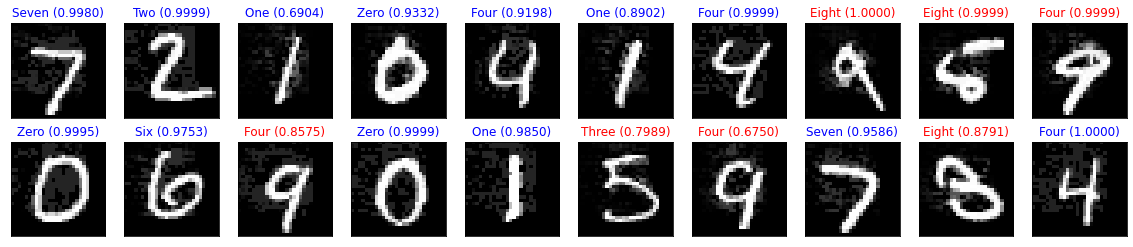

In [ ]:
adv_pred = model.predict(adv_img.numpy())
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_img[idx].numpy().reshape(28, 28), 0, 1), cmap = 'gray')
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[y_val[idx]]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s (%.4f)' %(class_names[np.argmax(adv_pred[idx])], adv_pred[idx].max()), color = color)

In [ ]:
print("Average L1 Norm: ", round(tf.norm(perturb, ord = 1).numpy() / len(x_test), 4))
print("Average L2 Norm: ", round(tf.norm(perturb, ord = 2).numpy()/ len(x_test), 4))
print("Average L_inf Norm: ", round(tf.norm(perturb - x_test, ord = np.inf).numpy()/ len(x_test), 4))

Average L1 Norm:  24.8021
Average L2 Norm:  0.0618
Average L_inf Norm:  0.0015


In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), y_test)
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 0s 4ms/step - loss: 1.3757 - accuracy: 0.6840

Model Accuracy on test images:  0.684
Model Loss on test images:  1.3757


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove FGSM putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/autoencoder_mnist_dfa.h5')

In [ ]:
# Restore adversarial images created due to FGSM attack 
denise_images =d_model.predict(adv_img.numpy())

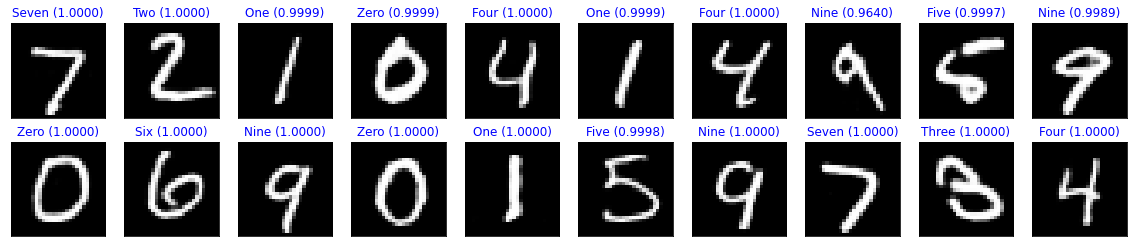

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  
  if class_names[y_val[idx]] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx].reshape(28, 28), cmap = 'gray')
  plt.title('%s (%.4f)' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)
  

In [ ]:
ssim = tf.image.ssim(x_test,denise_images , max_val = 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
ssim = ssim.numpy()
print("Average Structure Similarity Index between original and restored Examples:", round(ssim.mean(), 4))
print()

psnr = tf.image.psnr(x_test, denise_images, max_val = 255)
psnr = psnr.numpy()
print("Average Peak Signal-to-Noise Ratio between original and restored Examples:", psnr.mean())

Average Structure Similarity Index between original and restored Examples: 0.9788

Average Peak Signal-to-Noise Ratio between original and restored Examples: 76.45614


In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, y_test)
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 0s 4ms/step - loss: 0.0810 - accuracy: 0.9780

Model Accuracy on restored images:  0.978
Model Loss on test images:  0.081


In [ ]:
print('Sucess rate of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess rate of Defence Model:  0.9909


# Carlini and Wanger Attack

In [ ]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
pred = model.predict(x_test[:1000])

label = []
for i in range(len(pred)):
  y_pred = np.argmax(pred[i])
  l = label.append(y_pred) 


labels = np.asarray(label)

images = tf.cast(x_test[:1000], dtype = tf.float32)
labels = tf.cast(labels, dtype = tf.int32)

images = ep.astensor(images)
labels = ep.astensor(labels)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

# create attack
attack = foolbox.attacks.L2CarliniWagnerAttack()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c, epsilons = 5)

# adversarial purtubation
perturb = adv_img - x_test[:1000]

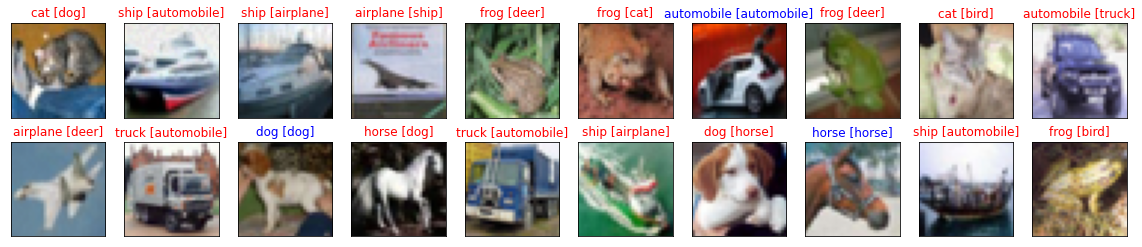

In [ ]:
adv_pred = model.predict(adv_img.numpy())
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_img[idx].numpy(), 0, 1), cmap = 'gray')
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[np.argmax(y_test[idx])]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title(class_names[np.argmax(y_test[idx])] + " [" + class_names[int(np.argmax(adv_pred[idx]))] + "]", color = color)

In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), y_test[:1000])
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 0s 13ms/step - loss: 1.1845 - accuracy: 0.1450

Model Accuracy on test images:  0.145
Model Loss on test images:  1.1845


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove FGSM putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/cifar10/cifar10_cwa.h5')

In [ ]:
# Restore adversarial images created due to FGSM attack 
denise_images =d_model.predict(adv_img.numpy())

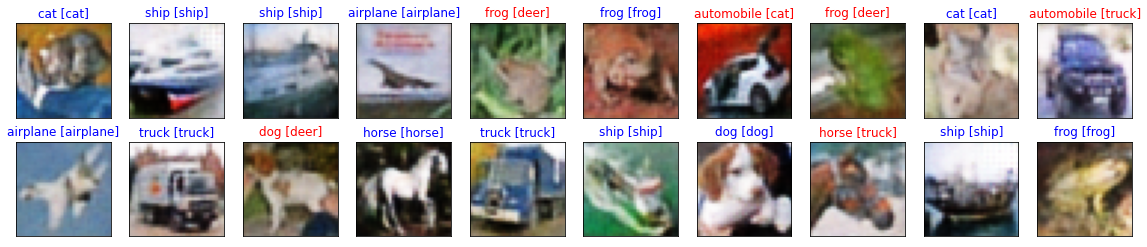

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  #plt.imshow(denise_images[idx].reshape(28, 28), cmap = 'gray')
  
  if class_names[np.argmax(y_test[idx])] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx], cmap = 'gray')
  plt.title(class_names[np.argmax(y_test[idx])] + ' [' + class_names[np.argmax(predictions[idx])] + ']', color =  color)
  

In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, y_test[:1000])
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 0s 13ms/step - loss: 0.8965 - accuracy: 0.7150

Model Accuracy on restored images:  0.715
Model Loss on test images:  0.8965


In [ ]:
print('Sucess of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess of Defence Model:  0.9458


# 6. Spatial attack and Reconstruction of Adverasarial Examples

In [21]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [22]:
images = tf.cast(x_test, dtype = tf.float32)
labels = tf.cast(y_test, dtype = tf.int32)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

eps = [0.3]

# create attack
attack = foolbox.attacks.SpatialAttack()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c)

# adversarial purtubation
perturb = adv_img - x_test

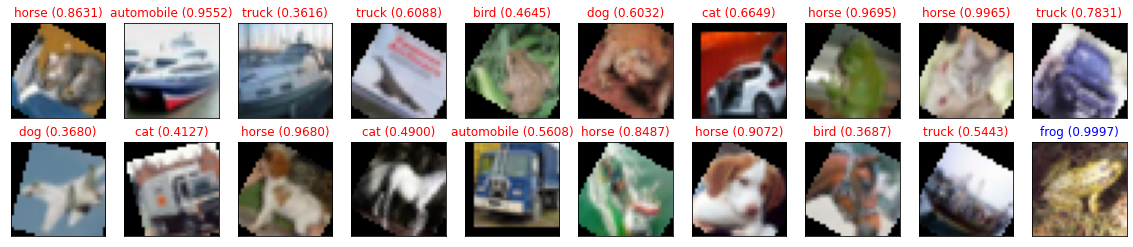

In [26]:
adv_pred = model.predict(adv_img.numpy())
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_img[idx].numpy(), 0, 1), cmap = 'gray')
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[y_test[idx]]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s (%.4f)' %(class_names[np.argmax(adv_pred[idx])], adv_pred[idx].max()), color = color)

In [27]:
print("Average L1 Norm: ", round(tf.norm(perturb, ord = 1).numpy() / len(x_test), 4))
print("Average L2 Norm: ", round(tf.norm(perturb, ord = 2).numpy()/ len(x_test), 4))
print("Average L_inf Norm: ", round(tf.norm(perturb - x_test, ord = np.inf).numpy()/ len(x_test), 4))

Average L1 Norm:  575.8626
Average L2 Norm:  0.5249
Average L_inf Norm:  0.002


In [33]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img[:1000].numpy(), tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 1s 33ms/step - loss: 2.7408 - accuracy: 0.0170

Model Accuracy on test images:  0.017
Model Loss on test images:  2.7408


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# load denoising model to remove FGSM putrbation
d_model = tf.keras.models.load_model('/content/drive/MyDrive/PhD_Thesis/Generative_Models/cifar10/cifar10_spa.h5')

In [36]:
# Restore adversarial images created due to FGSM attack 
denise_images =d_model.predict(adv_img.numpy())

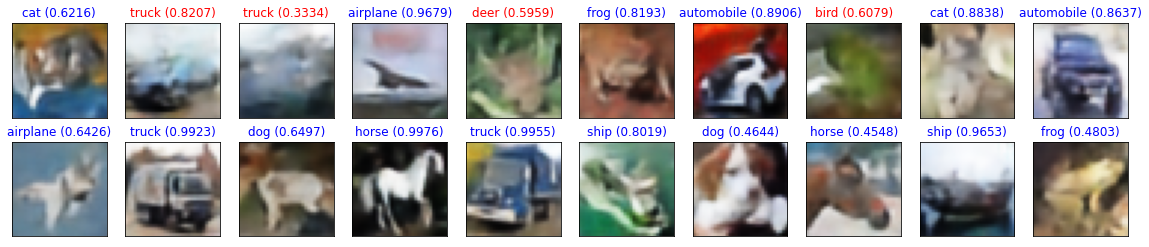

In [39]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  
  if class_names[y_test[idx]] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx])
  plt.title('%s (%.4f)' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)
  

In [40]:
ssim = tf.image.ssim(x_test,denise_images , max_val = 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
ssim = ssim.numpy()
print("Average Structure Similarity Index between original and restored Examples:", round(ssim.mean(), 4))
print()

psnr = tf.image.psnr(x_test, denise_images, max_val = 255)
psnr = psnr.numpy()
print("Average Peak Signal-to-Noise Ratio between original and restored Examples:", psnr.mean())

Average Structure Similarity Index between original and restored Examples: 0.7914

Average Peak Signal-to-Noise Ratio between original and restored Examples: 73.22942


In [42]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 1s 31ms/step - loss: 1.3031 - accuracy: 0.6640

Model Accuracy on restored images:  0.664
Model Loss on test images:  1.3031


In [43]:
print('Sucess rate of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess rate of Defence Model:  0.8058
